In [1]:
%cd /home/x_amime/x_amime/projects/an_explanation_model/

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pandas as pd
import seaborn as sns
from glob import glob
import PIL
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import ttest_ind_from_stats as ttest
from source.project_manager import load_experiment_metadata

imshow_args = {"cmap": "jet"}

/home/x_amime/.conda/envs/xlab10/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/proj/azizpour-group/users/x_amime/projects/an_explanation_model


In [14]:
# run this without ? to compute aucs for an experiment
# run this with ? to merge
# run this with ? twice to merge aucs accross experiments
save_metadata_dir = "outputs/metadata/8_?_*/"
if "?" in save_metadata_dir:
    path_to_acc_data = "outputs/processed/8/8_acc_data.csv"
else:
    index = save_metadata_dir.index("_") + 1
    num = save_metadata_dir[index]
    path_to_acc_data = f"outputs/processed/8/8_{num}_acc_data.csv"

static_key = "ig_u_x_0"
static_combination = "damping"
index_cols = [
    "alpha_mask_value",
    "q_direction",
    "q_baseline_mask",
    "combination",
    "projection_type",
    "batch",
]
static_data_acc = pd.read_csv(
    "outputs/processed/8/8_static_acc_data.csv",
    index_col=index_cols,
)
static_data_acc.columns = static_data_acc.columns.astype(int)


def fill_na():
    alphas = merged_data_acc.index.get_level_values("alpha_mask_value").unique()
    for alpha in alphas:
        q_directions = (
            merged_data_acc.loc[alpha].index.get_level_values("q_direction").unique()
        )
        for q_direction in q_directions:
            q_baseline_masks = (
                merged_data_acc.loc[alpha, q_direction]
                .index.get_level_values("q_baseline_mask")
                .unique()
            )
            for q_baseline_mask in q_baseline_masks:
                combinations = (
                    merged_data_acc.loc[alpha, q_direction, q_baseline_mask]
                    .index.get_level_values("combination")
                    .unique()
                )
                for combination in combinations:
                    # select the key that is computed for 0 and 100
                    temp = static_data_acc.loc[
                        (static_key, "deletion", q_baseline_mask, static_combination),
                        [0, 100],
                    ]

                    # check if there are any nan values in the selected key
                    assert (
                        temp.isna().sum().sum() == 0
                    ), f"alpha: {alpha}, q_direction: {q_direction}, q_baseline_mask: {q_baseline_mask}, combination: {combination}"

                    # check if the index of the selected key is the same as the index of the merged_data_acc
                    index2 = temp.index
                    index1 = merged_data_acc.loc[
                        (alpha, q_direction, q_baseline_mask, combination), [0, 100]
                    ].index
                    assert (
                        index1.shape == index2.shape
                    ), f"shape mismatch {index1.shape}!={index2.shape} at alpha: {alpha}, q_direction: {q_direction}, q_baseline_mask: {q_baseline_mask}, combination: {combination}"
                    assert (
                        index1 != index2
                    ).sum() == 0, f"alpha: {alpha}, q_direction: {q_direction}, q_baseline_mask: {q_baseline_mask}, combination: {combination}"

                    # if the q_direction is insertion, we need to swap the columns
                    if q_direction == "insertion":
                        temp = temp.rename(columns={0: 100, 100: 0})
                        temp = temp[[0, 100]]

                    # replace the values in the merged_data_acc with the selected key
                    merged_data_acc.loc[
                        (alpha, q_direction, q_baseline_mask, combination), [0, 100]
                    ] = temp.values

    merged_data_acc.to_csv(path_to_acc_data)


if os.path.exists(path_to_acc_data):
    merged_data_acc = pd.read_csv(
        path_to_acc_data,
        index_col=index_cols,
    ).sort_index()
    merged_data_acc.columns = merged_data_acc.columns.astype(int)
    if 0 not in merged_data_acc.columns:
        merged_data_acc[0] = np.nan
    if 100 not in merged_data_acc.columns:
        merged_data_acc[100] = np.nan
    merged_data_acc = merged_data_acc.sort_index(axis=1)
    print("loaded acc data previously computed")
    num_na = merged_data_acc.isna().sum().sum()
    if num_na > 0:
        fill_na()
        print("filled na in the acc data")
    else:
        print("number of nan in acc data:", num_na)
elif "?" not in save_metadata_dir:
    paths = os.path.join(save_metadata_dir, "merged_igq_metadata.csv")
    paths = glob(paths)
    print(paths)
    merged_data = []
    for path in paths:
        slq_csv = pd.read_csv(path)
        batch = path.split("/")[-2].split("_")[-1]
        slq_csv["batch"] = batch

        if "additive" in path:
            slq_csv["combination"] = "additive"
        elif "convex" in path:
            slq_csv["combination"] = "convex"
        elif "damping" in path:
            slq_csv["combination"] = "damping"
        else:
            slq_csv["combination"] = None

        merged_data.append(slq_csv)
    merged_data = pd.concat(merged_data, axis=0)

    merged_data_acc = merged_data.pivot_table(
        index=index_cols,
        columns="q",
        values="preds",
        aggfunc="mean",
    )
    merged_data_acc.drop(columns=[0, 100], inplace=True, errors="ignore")
    merged_data_acc.to_csv(path_to_acc_data)
    print("computed acc data you need to run this cell again with ? to merge")
else:
    paths = glob("outputs/processed/8/8_?_acc_data.csv")
    merged_data_acc = []
    for path in paths:
        merged_data_acc.append(
            pd.read_csv(
                path,
                index_col=index_cols,
            ).sort_index()
        )
    print("concatenating acc data from different runs")
    merged_data_acc = pd.concat(merged_data_acc, axis=0)
    merged_data_acc.to_csv(path_to_acc_data)
    print("saved merged acc data please rerun this cell to fill na")

loaded acc data previously computed
filled na in the acc data


In [3]:
def auc(x):
    return np.trapz(y=x.values, x=[int(x) / 100 for x in x.index])


nice_names = {
    "ig_sg_i_u_x2_0_0.2": "XSL$^2(0,0.2)$",
    "ig_sg_i_u_x2_0_0.4": "XSL$^2(0,0.4)$",
    "ig_sg_i_u_x2_0_0.5": "XSL$^2(0,0.5)$",
    "ig_sg_i_u_x2_0_0.8": "XSL$^2(0,0.8)$",
    "ig_sg_i_u_x2_0_1.0": "XSL$^2(0,1.0)$",
    "ig_sg_i_u_x_0_0.2": "XSL(0,0.2)",
    "ig_sg_i_u_x_0_0.4": "XSL(0,0.4)",
    "ig_sg_i_u_x_0_0.5": "XSL(0,0.5)",
    "ig_sg_i_u_x_0_0.8": "XSL(0,0.8)",
    "ig_sg_i_u_x_0_1.0": "XSL(0,1.0)",
    "ig_sg_u_x2_0_0.1": "SL$^2(0,0.1)$",
    "ig_sg_u_x2_0_0.2": "SL$^2(0,0.2)$",
    "ig_sg_u_x2_0_0.5": "SL$^2(0,0.5)$",
    "ig_sg_u_x2_0_0.8": "SL$^2(0,0.8)$",
    "ig_sg_u_x2_0_1.0": "SL$^2(0,1.0)$",
    "ig_sg_u_x_0_0.1": "SL(0,0.1)",
    "ig_sg_u_x_0_0.2": "SL(0,0.2)",
    "ig_sg_u_x_0_0.5": "SL(0,0.5)",
    "ig_sg_u_x_0_0.8": "SL(0,0.8)",
    "ig_sg_u_x_0_1.0": "SL(0,1.0)",
    "sl_u_x2_0_0.2": "SLT$^2$(0,0.2)",
    "sl_u_x2_0_0.4": "SLT$^2$(0,0.4)",
    "sl_u_x2_0_0.5": "SLT$^2$(0,0.5)",
    "sl_u_x2_0_0.8": "SLT$^2$(0,0.8)",
    "sl_u_x2_0_1.0": "SLT$^2$(0,1.0)",
    "ig_sg_u_x2_0.1": "SG$^2$(0.1)",
    "ig_sg_u_x2_0.2": "SG$^2$(0.2)",
    "ig_sg_u_x2_0.5": "SG$^2$(0.5)",
    "ig_sg_u_x2_1.0": "SG$^2$(1.0)",
    "ig_sg_u_x_0.1": "SG(0.1)",
    "ig_sg_u_x_0.2": "SG(0.2)",
    "ig_sg_u_x_0.5": "SG(0.5)",
    "ig_sg_u_x_1.0": "SG(1.0)",
    "ig_vg_u_x_0": "SG(0.0)",
    "ig_vg_u_x2_0": "SG$^2$(0.0)",
    "ig_u_x_0": "IG(0.0)",
    "ig_u_x_0.1": "IG(0.1)",
    "ig_u_x_0.2": "IG(0.2)",
    "ig_u_x_0.5": "IG(0.5)",
    "ig_u_x_1.0": "IG(1.0)",
    "ig_u_x2_0": "IG$^2$(0.0)",
    "ig_u_x2_0.1": "IG$^2$(0.1)",
    "ig_u_x2_0.2": "IG$^2$(0.2)",
    "ig_u_x2_0.5": "IG$^2$(0.5)",
    "ig_u_x2_1.0": "IG$^2$(1.0)",
    "ig_u_x2_0_0.2": "IG$^2$(0,0.2)",
    "ig_u_x2_0_0.5": "IG$^2$(0,0.5)",
    "ig_u_x2_0_1.0": "IG$^2$(0,1.0)",
    "ig_u_x2_i_0_0.2": "XIG$^2$(0,0.2)",
    "ig_u_x2_i_0_0.5": "XIG$^2$(0,0.5)",
    "ig_u_x2_i_0_1.0": "XIG$^2$(0,1.0)",
    "ig_u_x_0_0.2": "IG(0,0.2)",
    "ig_u_x_0_0.5": "IG(0,0.5)",
    "ig_u_x_0_1.0": "IG(0,1.0)",
    "ig_u_x_i_0_0.2": "XIG(0,0.2)",
    "ig_u_x_i_0_0.5": "XIG(0,0.5)",
    "ig_u_x_i_0_1.0": "XIG(0,1.0)",
    "ig_occlusion_u_x_nan": "Occlusion",
    "ig_occlusion_u_x2_nan": "Occlusion$^2$",
    "ig_rise_u_x_0.1": "RISE(0.1)",
    "ig_rise_u_x2_0.1": "RISE(0.1)$^2$",
}

aucs = merged_data_acc.apply(lambda x: auc(x), axis=1)
aucs.name = "AUC"
alphas = aucs.index.get_level_values("alpha_mask_value").unique()
aucs = aucs.reset_index()
aucs = aucs.pivot_table(
    index=["alpha_mask_value"],
    columns=["projection_type", "q_direction", "q_baseline_mask", "combination"],
    values="AUC",
    aggfunc=["mean", "std"],
)
f_ = lambda x: f"{x:.3f}"

In [39]:
# apply ttest to the aucs
def significance_test(data: pd.Series):
    q_direction = data.index.get_level_values("q_direction").unique()
    assert len(q_direction) == 1, "q_direction should be unique"
    q_direction = q_direction[0]
    if q_direction == "insertion":
        target_fn = np.argmax
    else:
        target_fn = np.argmin
    data = data.droplevel("q_direction")
    data = data.unstack(level=0)
    target_id = target_fn(data["mean"])
    target_mean = data["mean"].iloc[target_id]
    target_std = data["std"].iloc[target_id]
    ttests = data.apply(
        lambda x: ttest(target_mean, target_std, 20, x["mean"], x["std"], 20).pvalue,
        axis=1,
    )
    ttests = (ttests > 0.05).astype(int)
    ttests.iloc[target_id] = 2
    return ttests


ttests = (
    aucs.stack(level=(0, 2, 4))
    .reorder_levels([2, 1, 3, 0])
    .sort_index()
    .groupby("q_direction")
    .apply(lambda x: x.apply(significance_test, axis=0))
)
ttests = ttests.unstack(level=0)
aucs = aucs.stack(level=(4)).reorder_levels([1, 0], axis=0).sort_index()
aucs = aucs.reorder_levels([0, 1, 3, 2], axis=1).sort_index(axis=1)
aucs = aucs.rename(index=nice_names)
aucs = aucs.sort_index()
ttests = ttests.rename(index=nice_names)
ttests = ttests.sort_index()

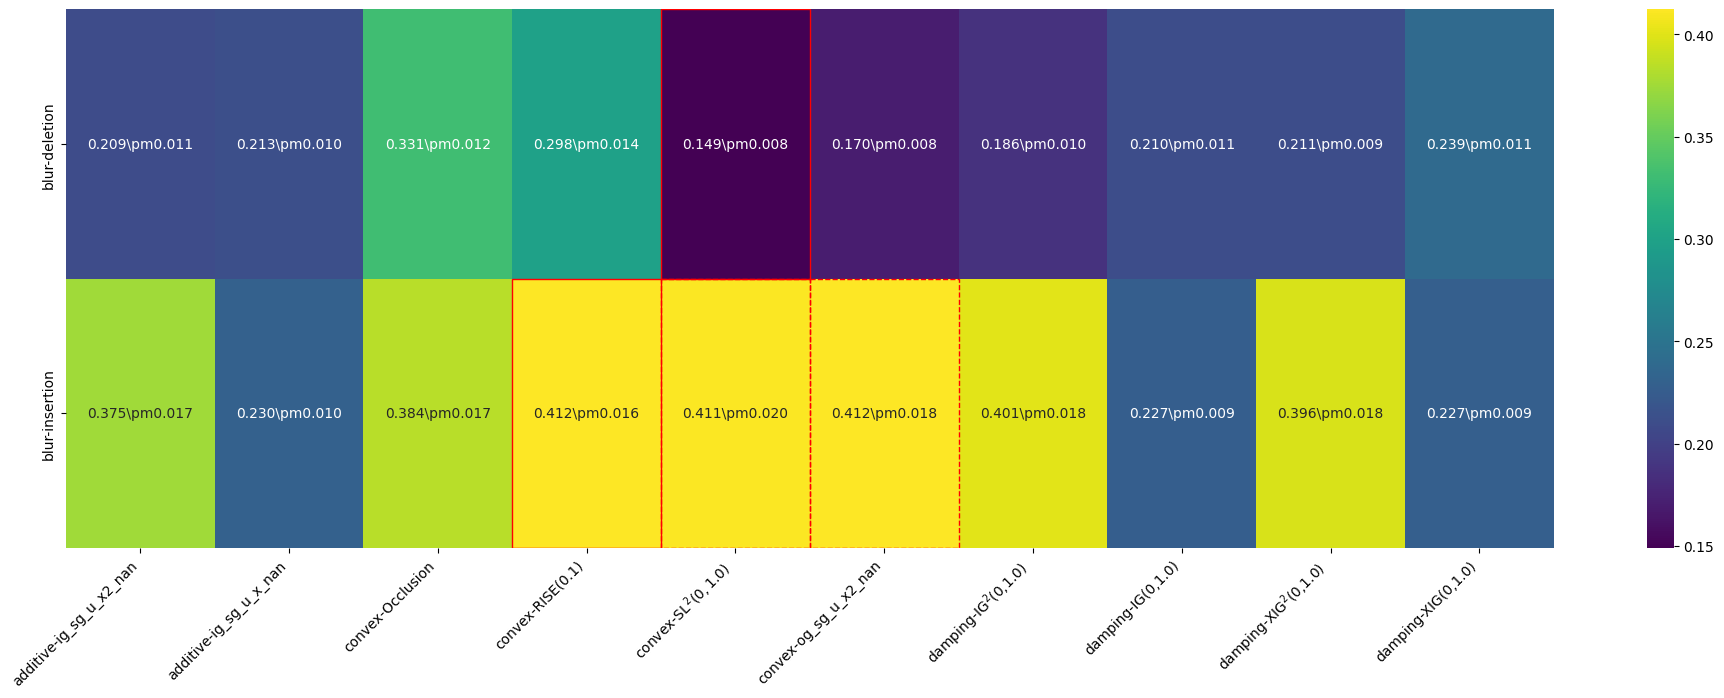

In [44]:
fig, axes = plt.subplots(
    1,
    1,
    figsize=(24, 7),
    sharey=True,
)
temp = aucs[("mean", "prediction")]
temp_std = aucs[("std", "prediction")]
annot = np.array(
    [
        rf"{m:.3f}\pm{s:.3f}"
        for m, s in zip(
            temp.values.ravel(),
            temp_std.values.ravel(),
        )
    ]
).reshape(np.shape(temp.values))

sns.heatmap(
    temp.T,
    annot=annot.T,
    fmt="",
    ax=axes,
    cmap="viridis",
)

# rotate labes

axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right")
axes.set_xlabel("")
axes.set_ylabel("")


# highlight the significant differences
def add_patches(_ttests, ax):
    for i in range(_ttests.loc["prediction"].shape[0]):
        for j in range(_ttests.loc["prediction"].shape[1]):
            if _ttests.loc["prediction"].iloc[i, j] == 1:
                ax.add_patch(
                    plt.Rectangle(
                        (j, i), 1, 1, fill=False, edgecolor="red", linestyle="dashed"
                    )
                )
            elif _ttests.loc["prediction"].iloc[i, j] == 2:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor="red"))


add_patches(ttests.T, ax=axes)
plt.savefig("outputs/figures/8_vitresent_auc_heatmap.pdf", bbox_inches="tight")

In [22]:
occlusion = aucs.loc[
    "ig_occlusion_u_x_nan", (slice(None), "prediction", slice(None), "blur", "convex")
].unstack(level=0)
# make it like mean+-std
occlusion = occlusion.map(f_)
occlusion = occlusion.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
occlusion

projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             convex         0.328\pm0.013
                 insertion    blur             convex         0.378\pm0.018
dtype: object

In [23]:
rise = aucs.loc[
    "ig_rise_u_x_0.1", (slice(None), "prediction", slice(None), "blur", "convex")
].unstack(level=0)
# make it like mean+-std
rise = rise.map(f_)
rise = rise.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
rise

projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             convex         0.295\pm0.014
                 insertion    blur             convex         0.405\pm0.013
dtype: object

In [24]:
xig = aucs.loc[
    "ig_u_x_i_0_1.0", (slice(None), "prediction", slice(None), "blur", "damping")
].unstack(level=0)
# make it like mean+-std
xig = xig.map(f_)
xig = xig.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
xig

projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             damping        0.237\pm0.010
                 insertion    blur             damping        0.225\pm0.010
dtype: object

In [25]:
xig2 = aucs.loc[
    "ig_u_x2_i_0_1.0", (slice(None), "prediction", slice(None), "blur", "damping")
].unstack(level=0)
# make it like mean+-std
xig2 = xig2.map(f_)
xig2 = xig2.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
xig2

projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             damping        0.209\pm0.011
                 insertion    blur             damping        0.391\pm0.018
dtype: object

In [26]:
ig = aucs.loc[
    "ig_u_x_0_1.0", (slice(None), "prediction", slice(None), "blur", "damping")
].unstack(level=0)
# make it like mean+-std
ig = ig.map(f_)
ig = ig.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
ig

projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             damping        0.206\pm0.010
                 insertion    blur             damping        0.224\pm0.008
dtype: object

In [27]:
ig2 = aucs.loc[
    "ig_u_x2_0_1.0", (slice(None), "prediction", slice(None), "blur", "damping")
].unstack(level=0)
# make it like mean+-std
ig2 = ig2.map(f_)
ig2 = ig2.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
ig2

projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             damping        0.184\pm0.010
                 insertion    blur             damping        0.395\pm0.017
dtype: object

In [29]:
osg = aucs.loc[
    "og_sg_u_x2_nan", (slice(None), "prediction", slice(None), "blur", "convex")
].unstack(level=0)
# make it like mean+-std
osg = osg.map(f_)
osg = osg.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
osg

projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             convex         0.167\pm0.008
                 insertion    blur             convex         0.404\pm0.017
dtype: object

In [30]:
sg = aucs.loc[
    "ig_sg_u_x_nan", (slice(None), "prediction", slice(None), "blur", "additive")
].unstack(level=0)
# make it like mean+-std
sg = sg.map(f_)
sg = sg.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
sg

projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             additive       0.208\pm0.008
                 insertion    blur             additive       0.227\pm0.010
dtype: object

In [31]:
sg2 = aucs.loc[
    "ig_sg_u_x2_nan", (slice(None), "prediction", slice(None), "blur", "additive")
].unstack(level=0)
# make it like mean+-std
sg2 = sg2.map(f_)
sg2 = sg2.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
sg2

projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             additive       0.206\pm0.010
                 insertion    blur             additive       0.370\pm0.019
dtype: object

In [33]:
igsg = aucs.loc[
    "ig_sg_u_x2_0_1.0", (slice(None), "prediction", slice(None), "blur", "convex")
].unstack(level=0)
# make it like mean+-std
igsg = igsg.map(f_)
igsg = igsg.apply(lambda x: f"{x['mean']}\\pm{x['std']}", axis=1)
igsg

projection_type  q_direction  q_baseline_mask  combination
prediction       deletion     blur             convex         0.146\pm0.007
                 insertion    blur             convex         0.403\pm0.021
dtype: object

# JUNK YARD

In [10]:
ttest(0.209, 0.011, 20, 0.170, 0.008, 20).pvalue

2.230634753126728e-15

In [ ]:
def compute_norm_df(x):
    y = 0
    sigma = x.alpha_mask_value.iloc[0]

    def compute_norm(x):
        x = np.load(x).sum() * (sigma ** (5 / 2))
        return y + x

    y = x["data_path"].apply(compute_norm)
    return y.mean(), y.std()


kcsim = temp.groupby("alpha_mask_value").apply(compute_norm_df)
kcsim_mean = kcsim.apply(lambda x: x[0])
kcsim_std = kcsim.apply(lambda x: x[1])
plt.plot(kcsim_mean, label="mean")
plt.plot(kcsim_mean + kcsim_std, label="mean+std")
plt.plot(kcsim_mean - kcsim_std, label="mean-std")
plt.title("Entropy CBIS-DDSM sim")
plt.savefig("outputs/figures/8_cbisddsm_sim_2.pdf", bbox_inches="tight")

In [ ]:
# caltech birds
import tensorflow_datasets as tfds

# build a datasource cub 200
data_dir = "/proj/azizpour-group/datasets/CUB_200_2011/tf_records"
manual_dir = "/proj/azizpour-group/datasets/CUB_200_2011/downloads"
name = "caltech_birds2011"
# builder = tfds.builder(
#     name,
# #     file_format="array_record",
#     data_dir=data_dir,
#     version="0.1.1",
# )

# builder.download_and_prepare(download_config=tfds.download.DownloadConfig(manual_dir=manual_dir))
# # ds = builder.as_data_source()
ds = tfds.load(name, data_dir=data_dir)

In [ ]:
static_key = "ig_u_x_0"
combination = "damping"


def get_static_acc_data_df(batch):
    static_data_acc = pd.read_csv(
        f"outputs/metadata/8_0_{combination}_{batch}/merged_igq_metadata.csv"
    )
    static_data_acc = static_data_acc.set_index(
        ["alpha_mask_value", "q", "q_direction"]
    ).loc[
        (static_key, [0, 100], "deletion"),
    ]
    static_data_acc["batch"] = batch
    static_data_acc["combination"] = combination
    return static_data_acc.pivot_table(
        columns="q",
        index=[
            "alpha_mask_value",
            "q_direction",
            "q_baseline_mask",
            "combination",
            "projection_type",
            "batch",
        ],
        values="preds",
        aggfunc="mean",
    )


def get_static_acc_data():
    static_acc_data = []
    for batch in range(10):
        static_acc_data.append(get_static_acc_data_df(batch))
    static_acc_data = pd.concat(static_acc_data, axis=0)
    return static_acc_data


static_acc_data = get_static_acc_data()

static_acc_data.to_csv("outputs/processed/8/8_static_acc_data.csv")

In [32]:
masked_image = {}
actual_q = {}
explanation_smoothed_q = {}

In [41]:
from source.data_manager import imagenet_loader_from_metadata

save_metadata_dir = "outputs/metadata/8_0_*_0/"
sl_metadata = load_experiment_metadata(save_metadata_dir, 
                                       glob_path="*_ig_*.csv")
ids = sl_metadata["stream_name"] == "vanilla_grad_mask"
sl_metadata = sl_metadata[ids]
sl_metadata = sl_metadata.reset_index(drop=True)
sl_metadata["image_path"] = sl_metadata["image_path"].apply(
    lambda npy_path: npy_path.replace("/scratch/local/data",
                                      "/proj/azizpour-group/datasets"))

kernels = [(1, 1), (3, 3), (5, 5), (7, 7)]
for smoothing_kernel_shape in kernels:
    ds = imagenet_loader_from_metadata(
        sl_metadata,
        q=1,
        input_shape=(224, 224, 3),
        direction="deletion",
        batch_size=2,
        prefetch_factor=1,
        smoothing_kernel_shape=smoothing_kernel_shape,
        verbose=True,
    )

    for item in ds:
        break
    print(list(item.keys()))

    masked_image[smoothing_kernel_shape] = item["masked_image"][0].numpy()
    actual_q[smoothing_kernel_shape] = f"{item['actual_q'][0].numpy():.2f}"
    explanation_smoothed_q[smoothing_kernel_shape] = item["explanation_smoothed_q"][0].numpy()

['original_image', 'saliency', 'masked_image', 'baseline', 'label', 'explanation_smoothed_q', 'explanation_q', 'theoretical_q', 'actual_q']
['original_image', 'saliency', 'masked_image', 'baseline', 'label', 'explanation_smoothed_q', 'explanation_q', 'theoretical_q', 'actual_q']
['original_image', 'saliency', 'masked_image', 'baseline', 'label', 'explanation_smoothed_q', 'explanation_q', 'theoretical_q', 'actual_q']
['original_image', 'saliency', 'masked_image', 'baseline', 'label', 'explanation_smoothed_q', 'explanation_q', 'theoretical_q', 'actual_q']


In [26]:
import tensorflow as tf

print(tf.reduce_min(item["explanation_smoothed_q"][0]), 
      tf.reduce_max(item["explanation_smoothed_q"][0]))

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


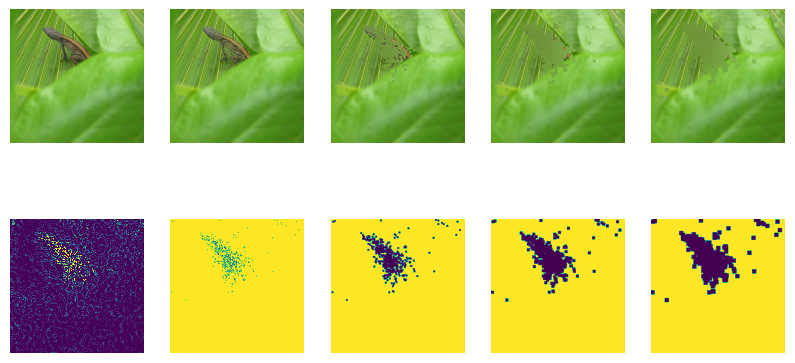

In [61]:
from source.data_manager import save_axis


fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for ax in axes.ravel():
    ax.axis("off")
names_row1 = []
names_row2 = []
axes[0, 0].imshow(item["original_image"][0])
# axes[0, 0].set_title("Original")
names_row1.append("Original")
saliency = item["saliency"][0].numpy()
mean = saliency.mean()
std = saliency.std()
axes[1, 0].imshow(item["saliency"][0], vmin=0, vmax=mean + 2 * std)
names_row2.append("Saliency")
# axes[1, 0].set_title("Saliency")

for i, kernel in enumerate(kernels, 1):
    axes[0, i].imshow(masked_image[kernel])
    # axes[0, i].set_title(f"Removal: {actual_q[kernel]}")
    names_row1.append(f"Removal: {actual_q[kernel]}")
    axes[1, i].imshow(explanation_smoothed_q[kernel])
    # axes[1, i].set_title(f"Erosion: {kernel}")
    names_row2.append(f"Erosion: {kernel}")
names = names_row1 + names_row2
save_axis(
    names=names, fig=fig, axes=axes, save_output_dir="outputs/figures/kernel_ablation"
)